# <span style="color:green"> Run on python 3.6</span>

# Explanations:

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных. (но можно добавлять некоторые параметры в ядро и их градиентными методами "обучать", потому что все что мы делаем - перемножаем матрицы и используем элементарные функции)

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

В данный момент при вычислении псевдообратной матрицы очень большая ошибка получается

In [1]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

---

# Hyperparameters:

In [3]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 10     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 64

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = K     # Размерность аутпута модели

In [4]:
f'p: {CFG.p}, r_cut: {CFG.r_cut}'

'p: [1.80473146 1.2260814  1.89406169 2.17089023 1.32397021 2.04143758\n 1.65210225 2.39837248 1.7327891  2.67274902], r_cut: [9.35062068 7.91138464 6.3941947  5.92955616 7.05550064 5.58687774\n 8.42484372 7.1880553  7.78114663 6.83540161]'

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [5]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [6]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [7]:
from sklearn.preprocessing import normalize

In [8]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [9]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X, A

In [10]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [11]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [12]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [13]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.inv(A.T @ A) @ A.T

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number)
            
            if transform:
                x = transform(x)
            else:
                x = torch.tensor(x)
            x = x.to(torch.float)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)

            dataset.append(
                (x, torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [14]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 1.1201671361923218
std = 0.3449265956878662

In [15]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [16]:
dataset = create_tensor_dataset(coords_file_path='coords2.csv', forces_file_path='forces2.csv', step=100)

# Uncomment, when calculated and changed mean and std:

# dataset = create_tensor_dataset('coords2.csv', 'forces2.csv', step=40, transform=transform)

Progress for atom 1: 100%|██████████| 468/468 [00:00<00:00, 577.68it/s]


In [17]:
dataset[400]

(tensor([[[0.9049, 0.9049, 0.9049, 0.9049, 0.9049, 0.9049, 0.9049, 0.9049,
           0.9049, 0.9049],
          [0.7735, 0.7735, 0.7735, 0.7735, 0.7735, 0.7735, 0.7735, 0.7735,
           0.7735, 0.7735],
          [0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326,
           0.8326, 0.8326],
          [0.8450, 0.8450, 0.8450, 0.8450, 0.8450, 0.8450, 0.8450, 0.8450,
           0.8450, 0.8450],
          [0.7648, 0.7648, 0.7648, 0.7648, 0.7648, 0.7648, 0.7648, 0.7648,
           0.7648, 0.7648],
          [0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093, 0.8093,
           0.8093, 0.8093],
          [0.8656, 0.8656, 0.8656, 0.8656, 0.8656, 0.8656, 0.8656, 0.8656,
           0.8656, 0.8656],
          [0.9157, 0.9157, 0.9157, 0.9157, 0.9157, 0.9157, 0.9157, 0.9157,
           0.9157, 0.9157],
          [0.8601, 0.8601, 0.8601, 0.8601, 0.8601, 0.8601, 0.8601, 0.8601,
           0.8601, 0.8601],
          [0.9265, 0.9265, 0.9265, 0.9265, 0.9265, 0.9265, 0.9265, 0.9265

Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [18]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[400][0].size(), train_data[400][0]

(torch.Size([1, 10, 10]),
 tensor([[[0.9349, 0.9349, 0.9349, 0.9349, 0.9349, 0.9349, 0.9349, 0.9349,
           0.9349, 0.9349],
          [0.8217, 0.8217, 0.8217, 0.8217, 0.8217, 0.8217, 0.8217, 0.8217,
           0.8217, 0.8217],
          [0.8860, 0.8860, 0.8860, 0.8860, 0.8860, 0.8860, 0.8860, 0.8860,
           0.8860, 0.8860],
          [0.9006, 0.9006, 0.9006, 0.9006, 0.9006, 0.9006, 0.9006, 0.9006,
           0.9006, 0.9006],
          [0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182, 0.8182,
           0.8182, 0.8182],
          [0.8735, 0.8735, 0.8735, 0.8735, 0.8735, 0.8735, 0.8735, 0.8735,
           0.8735, 0.8735],
          [0.9044, 0.9044, 0.9044, 0.9044, 0.9044, 0.9044, 0.9044, 0.9044,
           0.9044, 0.9044],
          [0.9492, 0.9492, 0.9492, 0.9492, 0.9492, 0.9492, 0.9492, 0.9492,
           0.9492, 0.9492],
          [0.9020, 0.9020, 0.9020, 0.9020, 0.9020, 0.9020, 0.9020, 0.9020,
           0.9020, 0.9020],
          [0.9584, 0.9584, 0.9584, 0.9584, 0.95

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [19]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 0.8780792951583862, std = 0.0711849182844162


## Когда молекул уже будет много как хранить данные:

In [20]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [22]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [23]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [24]:
next(iter(train_loader))[0].size()  # [batch_size, Channels, Height, Width]

torch.Size([64, 1, 10, 10])

---

# Обучение:

In [25]:
# from torch.utils.tensorboard import SummaryWriter

## 1)Многомерный аутпут:

In [26]:
import torch.nn.functional as F
import torch.cuda.amp as amp

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [27]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

        return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [28]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

In [29]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, convolution=None, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()
        if convolution and flattened_size == CFG.K * CFG.K:
            raise Exception('PASSED CONV LAYERS, BUT DID NOT PASS FLATTENED SIZE')

        self.conv_layers = flattener()

        if convolution:
            self.conv_layers = convolution

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 1024),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),

            nn.Linear(256, 128),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size)
        )

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 128),
        #     activation,
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, output_size),
        # )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.conv_layers(x)

        x = self.FC(x)

        return x

В качестве метрики буду использовать сумму MSE по компонентам, лоссы можно разные пробовать

In [30]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim, A_pinv, F_3D)

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0

    scheduler.step()

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device).detach()   # здесь можно не делать detach и обучать матрицу A

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update() 

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()
        processed_data += inputs.size(0)

    # print(outputs)
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [31]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs, 2)).to(torch.device("cpu")) 
        outputs_3D = torch.squeeze(outputs_3D, -1)

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum')
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size

    return val_loss, val_MSE

In [32]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
    return history

In [33]:
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict

In [34]:
__conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=3),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            # activation,
            # nn.MaxPool2d(kernel_size=3),
            # nn.BatchNorm2d(num_features=8)

            flattener()
)

# Код для проверки длины конкатенированного вектора на вход в FC:

# t = next(iter(train_loader))
# a = conv_layers(t[0])
# a.size()
# a.view(a.size(0), -1).size()

In [35]:
model = SingleNet(
    output_size=CFG.output_size,
    # activation=nn.Tanh(),
    convolution=None,
    ).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.1)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [36]:
model

SingleNet(
  (conv_layers): flattener()
  (FC): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [37]:
history = train(
    
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler, epochs=100
)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]/home/alphonse/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:   4%|▍         | 4/100 [00:00<00:06, 15.89it/s]


Epoch 001 train_loss: 28.9390 val_loss 11.4866 train_MSE 42895.3204 val_MSE 2277.1677

Epoch 002 train_loss: 29.0701 val_loss 11.1985 train_MSE 284776.5669 val_MSE 3089.3216

Epoch 003 train_loss: 28.5589 val_loss 12.5368 train_MSE 22023.6285 val_MSE 6579.6262

Epoch 004 train_loss: 26.6265 val_loss 11.7177 train_MSE 41641.5458 val_MSE 124.9166


epoch:   9%|▉         | 9/100 [00:00<00:04, 19.37it/s]


Epoch 005 train_loss: 26.7404 val_loss 11.5080 train_MSE 9014.4361 val_MSE 246003.4693

Epoch 006 train_loss: 27.3821 val_loss 10.1497 train_MSE 71356.1124 val_MSE 121077.9029

Epoch 007 train_loss: 27.0649 val_loss 13.0494 train_MSE 6369.1684 val_MSE 11547.1691

Epoch 008 train_loss: 26.4738 val_loss 11.4044 train_MSE 56886.6386 val_MSE 5172.9357

Epoch 009 train_loss: 26.6169 val_loss 11.1708 train_MSE 20986.1226 val_MSE 7962.9183


epoch:  14%|█▍        | 14/100 [00:00<00:04, 19.76it/s]


Epoch 010 train_loss: 26.2744 val_loss 11.4107 train_MSE 4448.6115 val_MSE 5343.5344

Epoch 011 train_loss: 26.3674 val_loss 11.4394 train_MSE 40367.8042 val_MSE 4071.6816

Epoch 012 train_loss: 26.4505 val_loss 11.2977 train_MSE 13233.8590 val_MSE 4773.2941

Epoch 013 train_loss: 25.9815 val_loss 11.3149 train_MSE 2046.3714 val_MSE 4406.7367

Epoch 014 train_loss: 26.3806 val_loss 11.4519 train_MSE 11039.1037 val_MSE 1785.3024


epoch:  19%|█▉        | 19/100 [00:00<00:03, 20.32it/s]


Epoch 015 train_loss: 26.0512 val_loss 11.5022 train_MSE 3364.3070 val_MSE 1336.0605

Epoch 016 train_loss: 26.1731 val_loss 11.5849 train_MSE 8215.0429 val_MSE 493.5903

Epoch 017 train_loss: 26.0544 val_loss 11.5692 train_MSE 631.7345 val_MSE 648.9806

Epoch 018 train_loss: 26.0491 val_loss 11.4409 train_MSE 1580.9909 val_MSE 1533.6754

Epoch 019 train_loss: 26.1919 val_loss 11.5152 train_MSE 3100.6339 val_MSE 877.8545


epoch:  21%|██        | 21/100 [00:01<00:04, 16.63it/s]


Epoch 020 train_loss: 26.0736 val_loss 11.4569 train_MSE 2782.9165 val_MSE 1388.6704

Epoch 021 train_loss: 26.2657 val_loss 11.4375 train_MSE 3191.8985 val_MSE 1647.2938


epoch:  26%|██▌       | 26/100 [00:01<00:04, 17.60it/s]


Epoch 022 train_loss: 26.1597 val_loss 11.3888 train_MSE 37032.5788 val_MSE 2426.2807

Epoch 023 train_loss: 26.0418 val_loss 11.4049 train_MSE 1153.0872 val_MSE 2123.8085

Epoch 024 train_loss: 25.9558 val_loss 11.4148 train_MSE 14480.4747 val_MSE 2197.2977

Epoch 025 train_loss: 26.0312 val_loss 11.3595 train_MSE 15013.1213 val_MSE 3016.8394

Epoch 026 train_loss: 25.9578 val_loss 11.3660 train_MSE 7128.3988 val_MSE 2805.2605


epoch:  31%|███       | 31/100 [00:01<00:03, 18.79it/s]


Epoch 027 train_loss: 26.2235 val_loss 11.4331 train_MSE 3269.3210 val_MSE 2023.9359

Epoch 028 train_loss: 26.0750 val_loss 11.4114 train_MSE 3744.7514 val_MSE 2089.8477

Epoch 029 train_loss: 25.9251 val_loss 11.4332 train_MSE 2677.9337 val_MSE 1677.3673

Epoch 030 train_loss: 26.0180 val_loss 11.3704 train_MSE 6558.7660 val_MSE 2611.4233

Epoch 031 train_loss: 26.0392 val_loss 11.3891 train_MSE 5252.4963 val_MSE 2050.7039


epoch:  36%|███▌      | 36/100 [00:01<00:03, 20.46it/s]


Epoch 032 train_loss: 26.0629 val_loss 11.4277 train_MSE 7935.3825 val_MSE 1762.0303

Epoch 033 train_loss: 26.1014 val_loss 11.4235 train_MSE 10878.1658 val_MSE 1705.3030

Epoch 034 train_loss: 25.9526 val_loss 11.4177 train_MSE 33529.9964 val_MSE 1929.5639

Epoch 035 train_loss: 26.5339 val_loss 11.3625 train_MSE 4263.8663 val_MSE 2510.5785

Epoch 036 train_loss: 26.1992 val_loss 11.3501 train_MSE 1434.8769 val_MSE 2644.6760


epoch:  41%|████      | 41/100 [00:02<00:02, 21.36it/s]


Epoch 037 train_loss: 25.9485 val_loss 11.3867 train_MSE 13378.4790 val_MSE 2180.6240

Epoch 038 train_loss: 26.2262 val_loss 11.4281 train_MSE 30473.9369 val_MSE 1716.4197

Epoch 039 train_loss: 26.1152 val_loss 11.3797 train_MSE 1948.4677 val_MSE 2365.0965

Epoch 040 train_loss: 25.9679 val_loss 11.3863 train_MSE 1537.2842 val_MSE 2250.4763

Epoch 041 train_loss: 25.8265 val_loss 11.3580 train_MSE 6007.8518 val_MSE 2751.1535


epoch:  46%|████▌     | 46/100 [00:02<00:02, 21.77it/s]


Epoch 042 train_loss: 26.1991 val_loss 11.3727 train_MSE 34685.4209 val_MSE 2494.4187

Epoch 043 train_loss: 26.2635 val_loss 11.3754 train_MSE 2671.3070 val_MSE 2590.9248

Epoch 044 train_loss: 26.0080 val_loss 11.3747 train_MSE 6957.5285 val_MSE 2506.5429

Epoch 045 train_loss: 26.0810 val_loss 11.4068 train_MSE 1553.9203 val_MSE 2006.4027

Epoch 046 train_loss: 26.0018 val_loss 11.3613 train_MSE 1408.9101 val_MSE 2739.4792


epoch:  51%|█████     | 51/100 [00:02<00:02, 22.21it/s]


Epoch 047 train_loss: 26.0086 val_loss 11.3531 train_MSE 6057.0285 val_MSE 2760.3997

Epoch 048 train_loss: 25.9607 val_loss 11.3862 train_MSE 80743.4010 val_MSE 2259.8434

Epoch 049 train_loss: 25.9101 val_loss 11.4082 train_MSE 1760.2427 val_MSE 1844.2063

Epoch 050 train_loss: 25.9500 val_loss 11.3661 train_MSE 4550.1452 val_MSE 2547.3922

Epoch 051 train_loss: 26.0258 val_loss 11.3797 train_MSE 2456.5172 val_MSE 2366.7623


epoch:  56%|█████▌    | 56/100 [00:02<00:01, 22.24it/s]


Epoch 052 train_loss: 25.9916 val_loss 11.3777 train_MSE 2372.4906 val_MSE 2349.0489

Epoch 053 train_loss: 26.0322 val_loss 11.3634 train_MSE 2193.2528 val_MSE 2520.7898

Epoch 054 train_loss: 25.7427 val_loss 11.3925 train_MSE 8742.3325 val_MSE 2161.2332

Epoch 055 train_loss: 26.1581 val_loss 11.3884 train_MSE 8168.9352 val_MSE 2003.3297

Epoch 056 train_loss: 26.2675 val_loss 11.3563 train_MSE 9963.2514 val_MSE 2558.0728


epoch:  61%|██████    | 61/100 [00:03<00:01, 21.89it/s]


Epoch 057 train_loss: 25.9716 val_loss 11.3746 train_MSE 2531.3502 val_MSE 2432.9405

Epoch 058 train_loss: 26.1107 val_loss 11.3802 train_MSE 1741.0203 val_MSE 2565.0698

Epoch 059 train_loss: 25.8897 val_loss 11.3542 train_MSE 6520.8994 val_MSE 2731.1897

Epoch 060 train_loss: 26.1761 val_loss 11.3684 train_MSE 1518.7204 val_MSE 2552.4248

Epoch 061 train_loss: 25.9233 val_loss 11.3644 train_MSE 7722.2308 val_MSE 2807.5615


epoch:  66%|██████▌   | 66/100 [00:03<00:01, 22.29it/s]


Epoch 062 train_loss: 26.2595 val_loss 11.3689 train_MSE 1103.3747 val_MSE 2636.2864

Epoch 063 train_loss: 26.0229 val_loss 11.3585 train_MSE 2104.4657 val_MSE 2621.8764

Epoch 064 train_loss: 26.0703 val_loss 11.3517 train_MSE 6909.8572 val_MSE 2767.5449

Epoch 065 train_loss: 25.9672 val_loss 11.3708 train_MSE 7221.2890 val_MSE 2610.6066

Epoch 066 train_loss: 25.6034 val_loss 11.4115 train_MSE 10465.0465 val_MSE 1864.3064


epoch:  71%|███████   | 71/100 [00:03<00:01, 22.17it/s]


Epoch 067 train_loss: 25.9197 val_loss 11.4021 train_MSE 5426.3536 val_MSE 2136.4179

Epoch 068 train_loss: 25.9482 val_loss 11.3947 train_MSE 7833.3483 val_MSE 2097.0000

Epoch 069 train_loss: 26.3333 val_loss 11.4068 train_MSE 995.7719 val_MSE 2050.6434

Epoch 070 train_loss: 25.9434 val_loss 11.3690 train_MSE 70436.4105 val_MSE 2712.5981

Epoch 071 train_loss: 26.1805 val_loss 11.3679 train_MSE 4877.4400 val_MSE 2795.7427


epoch:  76%|███████▌  | 76/100 [00:03<00:01, 22.17it/s]


Epoch 072 train_loss: 26.0898 val_loss 11.3765 train_MSE 90672.8012 val_MSE 2326.9017

Epoch 073 train_loss: 26.2373 val_loss 11.4082 train_MSE 4185.1235 val_MSE 1892.6932

Epoch 074 train_loss: 26.2200 val_loss 11.3874 train_MSE 1463.3481 val_MSE 2078.0368

Epoch 075 train_loss: 25.9720 val_loss 11.3892 train_MSE 3024.5677 val_MSE 2221.3993

Epoch 076 train_loss: 25.9946 val_loss 11.3831 train_MSE 7202.6343 val_MSE 2085.0097


epoch:  81%|████████  | 81/100 [00:03<00:00, 21.20it/s]


Epoch 077 train_loss: 26.1382 val_loss 11.3858 train_MSE 15617.2683 val_MSE 2122.0417

Epoch 078 train_loss: 26.1893 val_loss 11.3915 train_MSE 18458.9671 val_MSE 2187.5619

Epoch 079 train_loss: 26.1551 val_loss 11.3757 train_MSE 1787.8989 val_MSE 2197.0496

Epoch 080 train_loss: 26.0651 val_loss 11.3614 train_MSE 1580.7824 val_MSE 2397.9165

Epoch 081 train_loss: 25.8630 val_loss 11.3968 train_MSE 2455.7109 val_MSE 2157.9871


epoch:  86%|████████▌ | 86/100 [00:04<00:00, 21.26it/s]


Epoch 082 train_loss: 26.0489 val_loss 11.3536 train_MSE 3239.3317 val_MSE 2576.2656

Epoch 083 train_loss: 26.0838 val_loss 11.3580 train_MSE 904.1823 val_MSE 2711.0494

Epoch 084 train_loss: 25.7499 val_loss 11.3865 train_MSE 7994.1036 val_MSE 2071.7375

Epoch 085 train_loss: 26.1074 val_loss 11.3972 train_MSE 2389.2313 val_MSE 2415.7407

Epoch 086 train_loss: 26.1027 val_loss 11.3842 train_MSE 17327.0077 val_MSE 2592.1131


epoch:  91%|█████████ | 91/100 [00:04<00:00, 21.60it/s]


Epoch 087 train_loss: 25.8594 val_loss 11.3751 train_MSE 9424.8673 val_MSE 2415.5237

Epoch 088 train_loss: 26.0990 val_loss 11.3871 train_MSE 44731.6412 val_MSE 2440.0941

Epoch 089 train_loss: 25.7325 val_loss 11.3796 train_MSE 3597.7434 val_MSE 2236.6729

Epoch 090 train_loss: 26.1458 val_loss 11.3320 train_MSE 26641.1679 val_MSE 3174.9252

Epoch 091 train_loss: 26.0306 val_loss 11.3337 train_MSE 6416.1708 val_MSE 2933.5896


epoch:  96%|█████████▌| 96/100 [00:04<00:00, 22.10it/s]


Epoch 092 train_loss: 25.9036 val_loss 11.3802 train_MSE 4502.2101 val_MSE 2400.8265

Epoch 093 train_loss: 25.8559 val_loss 11.3914 train_MSE 1505.4306 val_MSE 2043.6986

Epoch 094 train_loss: 26.0635 val_loss 11.3730 train_MSE 5999.6930 val_MSE 2434.0293

Epoch 095 train_loss: 26.0172 val_loss 11.3466 train_MSE 5525.7825 val_MSE 2865.3679

Epoch 096 train_loss: 25.9441 val_loss 11.3609 train_MSE 40025.9579 val_MSE 2668.2981


epoch: 100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


Epoch 097 train_loss: 26.1617 val_loss 11.3809 train_MSE 12321.1495 val_MSE 2266.9231

Epoch 098 train_loss: 25.8606 val_loss 11.4021 train_MSE 1192.7714 val_MSE 2029.2294

Epoch 099 train_loss: 26.2361 val_loss 11.3584 train_MSE 34997.9304 val_MSE 2548.2387

Epoch 100 train_loss: 26.0651 val_loss 11.3944 train_MSE 1980.8841 val_MSE 2118.0085


In [38]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

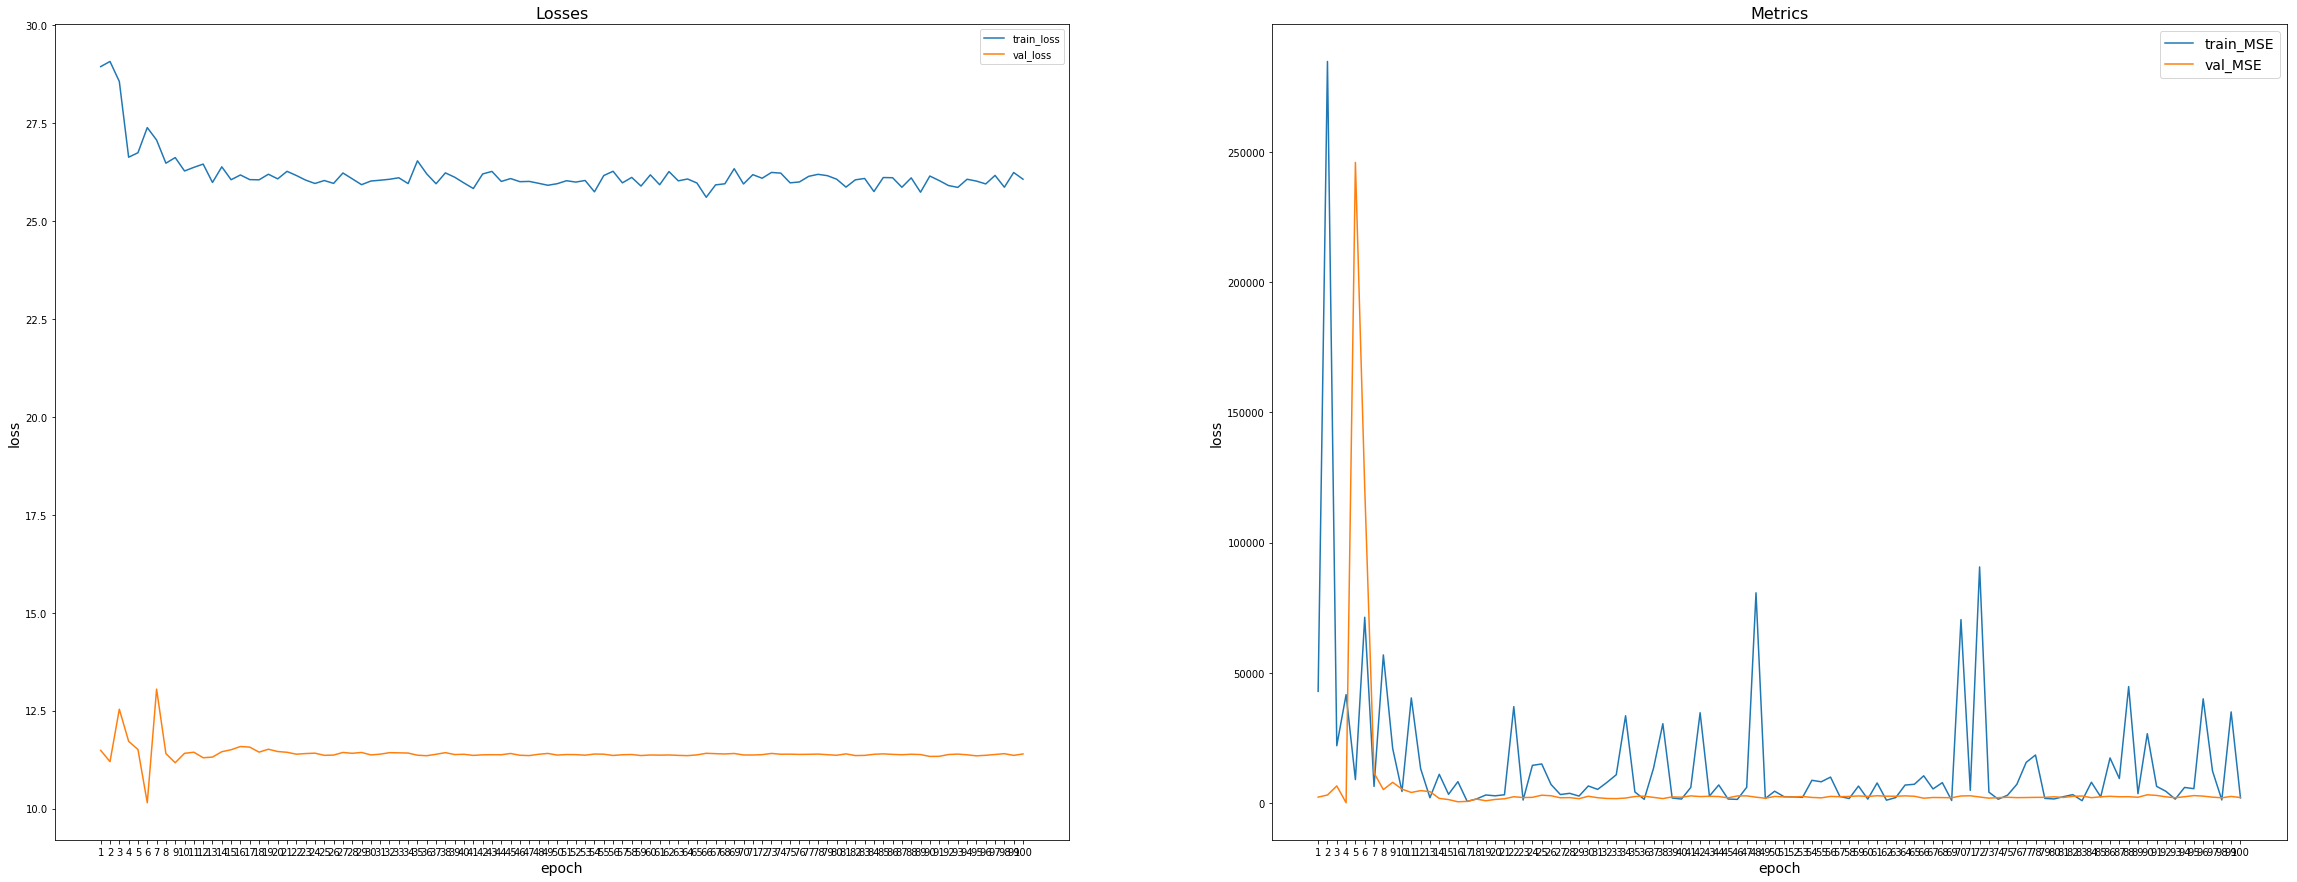

In [39]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [40]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [41]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [42]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [43]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

fl = flattener()
train_X = fl(torch.stack([elem[0] for elem in train_data]))
train_Y = fl(torch.stack([elem[1] for elem in train_data]))

val_X = fl(torch.stack([elem[0] for elem in val_data]))
val_Y = fl(torch.stack([elem[1] for elem in val_data]))

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [44]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=CFG.K, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [45]:
class MinusLogLikelihoodLoss:
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [46]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history of MSE and loss

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [47]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y):
    '''
    
    One go dataset evaluation function

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        output = model(val_X)
        loss = loss_obj(output, val_Y)

    predictions = likelihood(model(val_X))

    mean = predictions.mean
    print(mean)
    lower, upper = predictions.confidence_region()

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='mean').item()

    print(f'val_MSE = {val_MSE}, val_loss = {loss.item()}')

    return mean, lower, upper

In [48]:
class FeatureExtractor(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, extracted_size=CFG.K * CFG.K):
        super().__init__()

        # self.FC = nn.Sequential(
        #     nn.Linear(CFG.K * CFG.K, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, extracted_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(CFG.K * CFG.K, 128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, extracted_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):

        x = self.FC(x)

        return x

In [56]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=CFG.output_size)
feat_extractor = FeatureExtractor(extracted_size=32)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    # feature_extractor=feat_extractor
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)

loss_obj = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

**Одно и то же значение для mean выводится в состоянии model.train(), потому что мы выбрали ConstMean и это типо и есть наше среднее, которое мы вычисляем по трейновому датасету**

In [57]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    loss_obj=loss_obj,

    training_iterations=35,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.4423513412475586
Iter: 6, train_MSE = TODO, train_loss = 1.2703418731689453
Iter: 11, train_MSE = TODO, train_loss = 1.2379015684127808
Iter: 16, train_MSE = TODO, train_loss = 1.2103774547576904
Iter: 21, train_MSE = TODO, train_loss = 1.1513738632202148
Iter: 26, train_MSE = TODO, train_loss = 1.1253067255020142
Iter: 31, train_MSE = TODO, train_loss = 1.1448534727096558


одинаковые аутпуты в eval будут, если у нас очень резко сетка становится широкой из низкоразмерных данных, если мы используем feature_extractor, то есть та же проблема, что была с сетками просто

In [58]:
mean, lower, upper = GP_eval(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    loss_obj=loss_obj,
    val_X=val_X,
    val_Y=val_Y
)

In [52]:
val_Y

tensor([[-0.4979, -0.4979, -0.4979,  ..., -0.4979, -0.4979, -0.4979],
        [-0.0046, -0.0046, -0.0046,  ..., -0.0046, -0.0046, -0.0046],
        [-0.0768, -0.0768, -0.0768,  ..., -0.0768, -0.0768, -0.0768],
        ...,
        [-0.9187, -0.9187, -0.9187,  ..., -0.9187, -0.9187, -0.9187],
        [-0.8760, -0.8760, -0.8760,  ..., -0.8760, -0.8760, -0.8760],
        [-0.0789, -0.0789, -0.0789,  ..., -0.0789, -0.0789, -0.0789]])

## 3.2) Stochastic Variational GP Regression (обучение GPR по мини батчам):

---

# Пока мои выводы / результаты: 

- Про сетки:
    - Поскольку в датасете огромное количество сил очень маленькие - модель не в состоянии научиться определять болшьие силы, надо какой-то кастомный лосс придумывать, учитывающий это

    - Пока по какой-то причине сетка просто выдает одинаковый аутпут на весь батч на большом количестве частиц (и со свертками и без, и при большом и при маленьком K)

    - Для 2 частиц с K = 2 на одной сетке получилось val_MSE = 0.75

    - Для 50 частиц с K = 25 вообще ничего не вышло, с K = 5 пока тоже

Поэтому я пока отложу идею с 3 сетками и попробую покрутить GPR

- Про GP:
    - на 50 частицах пока оно не учится...

    - на 2 частицах результат получше, чем у сетки, но что-то мне подсказывает, что MSE довольно плохая метрика в нашей ситуации

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE